In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
pevogam_ucf101_path = kagglehub.dataset_download('pevogam/ucf101')

print('Data source import complete.')


Data source import complete.


In [ ]:
!ls /kaggle/input/ucf101/UCF101/UCF-101/

ApplyEyeMakeup	   Drumming	       MilitaryParade	   Shotput
ApplyLipstick	   Fencing	       Mixing		   SkateBoarding
Archery		   FieldHockeyPenalty  MoppingFloor	   Skiing
BabyCrawling	   FloorGymnastics     Nunchucks	   Skijet
BalanceBeam	   FrisbeeCatch        ParallelBars	   SkyDiving
BandMarching	   FrontCrawl	       PizzaTossing	   SoccerJuggling
BaseballPitch	   GolfSwing	       PlayingCello	   SoccerPenalty
Basketball	   Haircut	       PlayingDaf	   StillRings
BasketballDunk	   Hammering	       PlayingDhol	   SumoWrestling
BenchPress	   HammerThrow	       PlayingFlute	   Surfing
Biking		   HandstandPushups    PlayingGuitar	   Swing
Billiards	   HandstandWalking    PlayingPiano	   TableTennisShot
BlowDryHair	   HeadMassage	       PlayingSitar	   TaiChi
BlowingCandles	   HighJump	       PlayingTabla	   TennisSwing
BodyWeightSquats   HorseRace	       PlayingViolin	   ThrowDiscus
Bowling		   HorseRiding	       PoleVault	   TrampolineJumping
BoxingPunchingBag  HulaHoop	       PommelH

In [ ]:
!ls /kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist

classInd.txt	testlist02.txt	trainlist01.txt  trainlist03.txt
testlist01.txt	testlist03.txt	trainlist02.txt


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from urllib.request import urlopen
from tensorflow_docs.vis import embed

In [ ]:
class CFG:
    epochs = 20
    batch_size = 32
    classes = [
        "ApplyEyeMakeup", "ApplyLipstick", "Archery", "BabyCrawling", "BalanceBeam",
        "BandMarching", "BaseballPitch", "Basketball", "BasketballDunk", "BenchPress",
        "Biking", "Billiards", "BlowDryHair", "BlowingCandles", "BodyWeightSquats",
        "Bowling", "BoxingPunchingBag", "BoxingSpeedBag", "BreastStroke", "BrushingTeeth",
        "CleanAndJerk", "CliffDiving", "CricketBowling", "CricketShot", "CuttingInKitchen",
        "Diving", "Drumming", "Fencing", "FieldHockeyPenalty", "FloorGymnastics",
        "FrisbeeCatch", "FrontCrawl", "GolfSwing", "Haircut", "HammerThrow",
        "Hammering", "HandstandPushups", "HandstandWalking", "HeadMassage", "HighJump",
        "HorseRace", "HorseRiding", "HulaHoop", "IceDancing", "JavelinThrow",
        "JugglingBalls", "JumpingJack", "JumpRope", "Kayaking", "Knitting",
        "LongJump", "Lunges", "MilitaryParade", "Mixing", "MoppingFloor",
        "Nunchucks", "ParallelBars", "PizzaTossing", "PlayingCello", "PlayingDaf",
        "PlayingDhol", "PlayingFlute", "PlayingGuitar", "PlayingPiano", "PlayingSitar",
        "PlayingTabla", "PlayingViolin", "PoleVault", "PommelHorse", "PullUps",
        "Punch", "PushUps", "Rafting", "RockClimbingIndoor", "RopeClimbing",
        "Rowing", "SalsaSpin", "ShavingBeard", "Shotput", "SkateBoarding",
        "Skiing", "Skijet", "SkyDiving", "SoccerJuggling", "SoccerPenalty",
        "StillRings", "SumoWrestling", "Surfing", "Swing", "TableTennisShot",
        "TaiChi", "TennisSwing", "ThrowDiscus", "TrampolineJumping", "Typing",
        "UnevenBars", "VolleyballSpiking", "WalkingWithDog", "WallPushups", "WritingOnBoard",
        "YoYo"
    ]
    videos_per_class = 10

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def save_model(model, filepath):
    model.save(filepath)

In [ ]:
def classify_video_url(model, video_url, n_frames=10):
    # Download video from URL
    video = urlopen(video_url)
    with open('temp_video.avi', 'wb') as f:
        f.write(video.read())

    # Create frames from the downloaded video
    video_frames = frames_from_video_file('temp_video.avi', n_frames=n_frames)

    # Predict using the model
    predictions = model.predict(np.expand_dims(video_frames, axis=0))

    # Classify the video based on predictions
    predicted_class = np.argmax(predictions)
    predicted_class_name = CFG.classes[predicted_class]

    print(f"Predicted Class: {predicted_class_name}")
    return predicted_class_name

In [ ]:
# Load UCF101 dataset
file_paths = []
targets = []
for i, cls in enumerate(CFG.classes):
    sub_file_paths = glob.glob(f"/kaggle/input/ucf101/UCF101/UCF-101/{cls}/**.avi")[:CFG.videos_per_class]
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

In [ ]:
# file_paths = []
# targets = []
# for i, cls in enumerate(CFG.classes):
#     sub_file_paths = glob.glob(f"/kaggle/input/ucf101/UCF101/UCF-101/{cls}/**.avi")
#     file_paths += sub_file_paths
#     targets += [i] * len(sub_file_paths)

(10, 224, 224, 3)



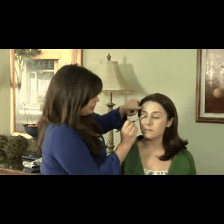

In [ ]:
# Create frames for a sample video
sample_video = frames_from_video_file(file_paths[0], n_frames=10)
print(sample_video.shape)
to_gif(sample_video)


In [ ]:
# Create features
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames=10))
features = np.array(features)

  0%|          | 0/1010 [00:00<?, ?it/s]

In [ ]:
# Split dataset
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)

In [ ]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(CFG.batch_size * 4).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Clean up memory
del train_features
del val_features
gc.collect()

17

In [ ]:
# Display shape of a batch
for X, y in train_ds.take(1):
    print(X.shape, y.shape)

(32, 10, 224, 224, 3) (32,)


In [ ]:
# Build model
net = tf.keras.applications.EfficientNetB0(include_top=False)
net.trainable = False

efficient_net_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(255.0),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(len(CFG.classes)),
    tf.keras.layers.GlobalAveragePooling3D()
])

efficient_net_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Train model
history = efficient_net_model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.ModelCheckpoint(
            "efficient_net_model.h5",
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=False
        )
    ]
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0492 - loss: 4.5483   

26/26 ━━━━━━━━━━━━━━━━━━━━ 296s 5s/step - accuracy: 0.0516 - loss: 4.5408 - val_accuracy: 0.2574 - val_loss: 3.7730
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.7061 - loss: 3.0434

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 808ms/step - accuracy: 0.7040 - loss: 3.0402 - val_accuracy: 0.5248 - val_loss: 2.9195
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.8421 - loss: 2.1561

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 812ms/step - accuracy: 0.8411 - loss: 2.1532 - val_accuracy: 0.5891 - val_loss: 2.3368
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9118 - loss: 1.5536

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 815ms/step - accuracy: 0.9113 - loss: 1.5516 - val_accuracy: 0.6485 - val_loss: 1.9638
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9337 - loss: 1.1622

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 821ms/step - accuracy: 0.9336 - loss: 1.1610 - val_accuracy: 0.6733 - val_loss: 1.7287
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9579 - loss: 0.9056

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 821ms/step - accuracy: 0.9576 - loss: 0.9048 - val_accuracy: 0.6980 - val_loss: 1.5752
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 807ms/step - accuracy: 0.9744 - loss: 0.7291 - val_accuracy: 0.6980 - val_loss: 1.4647
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9804 - loss: 0.5989

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 819ms/step - accuracy: 0.9804 - loss: 0.5985 - val_accuracy: 0.7129 - val_loss: 1.3858
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 807ms/step - accuracy: 0.9820 - loss: 0.5029 - val_accuracy: 0.7129 - val_loss: 1.3267
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 806ms/step - accuracy: 0.9884 - loss: 0.4291 - val_accuracy: 0.7129 - val_loss: 1.2785
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9874 - loss: 0.3675

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 818ms/step - accuracy: 0.9875 - loss: 0.3673 - val_accuracy: 0.7178 - val_loss: 1.2430
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 806ms/step - accuracy: 0.9891 - loss: 0.3210 - val_accuracy: 0.7178 - val_loss: 1.2132
Epoch 13/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 808ms/step - accuracy: 0.9906 - loss: 0.2846 - val_accuracy: 0.7178 - val_loss: 1.1874
Epoch 14/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 807ms/step - accuracy: 0.9925 - loss: 0.2492 - val_accuracy: 0.7178 - val_loss: 1.1652
Epoch 15/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 808ms/step - accuracy: 0.9906 - loss: 0.2238 - val_accuracy: 0.7178 - val_loss: 1.1484
Epoch 16/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 808ms/step - accuracy: 0.9925 - loss: 0.2028 - val_accuracy: 0.7129 - val_loss: 1.1325
Epoch 17/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 808ms/step - accuracy: 0.9940 - loss: 0.1810 - val_accuracy: 0.7129 - val_loss: 1.1194
Epoch 18/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 807ms/step - accuracy: 0.9966 - loss: 0.1622 - val_accuracy

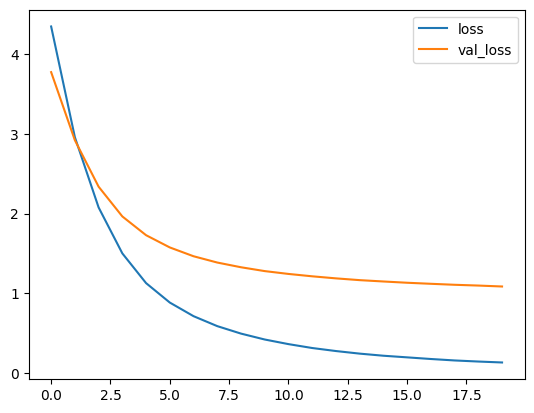

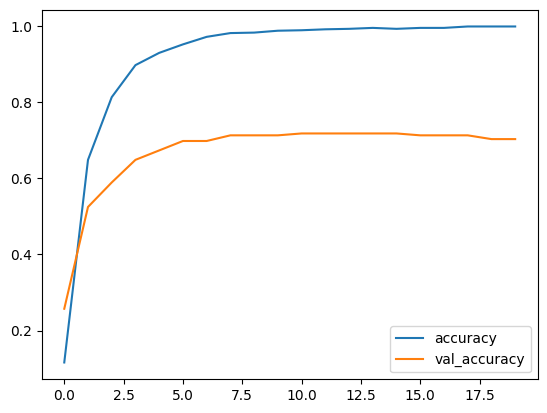

In [ ]:
# Plot training history
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

In [ ]:
# Evaluate model on validation set
val_loss, val_acc = efficient_net_model.evaluate(valid_ds)
print(f"Validation Loss: {val_loss} Validation Accuracy: {val_acc}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step - accuracy: 0.7099 - loss: 1.0502
Validation Loss: 1.0855363607406616 Validation Accuracy: 0.7029703259468079


In [ ]:
# Plot confusion matrix
val_predictions = np.argmax(efficient_net_model.predict(valid_ds), axis=1)
plot_confusion_matrix(val_targets, val_predictions, CFG.classes)

7/7 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step


In [ ]:
# Test classifying a video from a URL
video_url_to_classify = "https://www.engr.colostate.edu/me/facil/dynamics/files/drop.avi"
classify_video_url(efficient_net_model, video_url_to_classify)

1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step
Predicted Class: Mixing


'Mixing'

In [ ]:
efficient_net_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        'accuracy',]
)

In [ ]:
efficient_net_model.load_weights("efficient_net_model.h5")

results = efficient_net_model.evaluate(valid_ds)
for name, value in zip(efficient_net_model.metrics_names, results):
    print(f"{name}: {value:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.7286 - loss: 1.2099
loss: 1.2430
compile_metrics: 0.7178


In [ ]:
# Save the model
save_model(efficient_net_model, "Video_Classification_Model.h5")